In [1]:
!pip install --requirement /content/requirements_dev.txt

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import requests
import json
from google.colab import userdata

mode = "custom"

query_headers = {
    "accept": "application/json",
    "APCA-API-KEY-ID": userdata.get('apcaApiKeyId'),
    "APCA-API-SECRET-KEY": userdata.get('apcaApiSecretKey')}

In [2]:
from fn.monad import Option
from fn.monad import optionable
from urllib import parse as urlparse

from fn import _

# url (example): url = "https://data.alpaca.markets/v2/stocks/bars?symbols=MSFT%2CAAPL&timeframe=1Min&start=2024-02-12T00%3A00%3A00Z&end=2024-02-13T00%3A00%3A00Z&limit=10000&adjustment=raw&feed=sip&currency=USD&sort=asc"
class Pair_Request:
  def __init__(self,
               symbols,
               header=query_headers,
               start_date="2024-02-15T00%3A00%3A00Z",
               end_date="2024-02-20T00%3A00%3A00Z"):
        self.header = header
        self.start_date =start_date
        self.end_date = end_date
        self.symbols = symbols
        self.timeframe = "1Min"
        self.base_url = "https://data.alpaca.markets/v2/stocks/bars?symbols="
        self.query_params = self.set_query_params()
        self.url = self.base_url + self.set_query_params()


  def concat_symbols(self) -> str:
    return self.symbols[0] + "%2C" + self.symbols[1]


  def set_query_params(self) -> str:
    query_params = {"timeframe": self.timeframe,
          "start": self.start_date, "end": self.end_date,
          "limit": "1000&adjustment=raw&feed=sip&currency=USD&sort=asc"}
    return self.concat_symbols() + "&" + "&".join('='.join(param) for param in query_params.items())

  @optionable
  def execute(self):
    return requests.get(self.base_url + self.set_query_params(), headers=query_headers)

In [3]:
from fn.iters import map
from itertools import chain, combinations
from streams.Stream import Stream
import modin.pandas as pd
from streams.operations.operators import item

symbs_custom = ["MSFT", "AAPL", "AMZN", "NVDA", "META", "AVGO", "TSLA", "GOOGL", "AMD", "NFLX", "AEP", "MCHP", "NXPI"]
pairs_custom = list(combinations(symbs_custom, 2))

def list_nasdaq_symbols():
  url = 'https://en.m.wikipedia.org/wiki/Nasdaq-100'
  wiki_df = pd.read_html(url,
                         attrs={'id': "constituents"},
                         index_col='Ticker')[0]
  nasdaq_symbols = wiki_df.index.to_list()
  return list(combinations(nasdaq_symbols, 2))

if mode == "custom":
  input_pairs = pairs_custom
else:
  input_pairs = list_nasdaq_symbols()

In [4]:
nasdaq_symbols_bars = (Stream
           .create(input_pairs)
           .map(lambda symbols_tuple: Pair_Request(symbols=symbols_tuple))
           .map(lambda pair_req: pair_req.execute())
           .map(lambda res: res.map(_.text).get_or("[]"))
           .map(lambda json_str: json.loads(json_str))
           .map(item['bars']))

<a id='sec1'></a>
# Preprocess collected pairs with MODIN

In [5]:
import numpy as np

def json_to_df(json_data):
  df_json = pd.DataFrame.from_dict(json_data, orient="index").stack().to_frame()
  pairs_df = pd.DataFrame(df_json[0].values.tolist(), index=df_json.index)
  return (tuple(json_data.keys()), pairs_df)

pairs_df = (nasdaq_symbols_bars
            .map(lambda pairs_bars_json: json_to_df(pairs_bars_json)).asList())


#Example for tests
#print(pairs_df.take(1).asList())
#f_json_columns

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.
INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:37355
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46145'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36667'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:46793', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:46793
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:35576
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:44385', name: 1, status: init, memory: 0, processi

In [12]:
import numpy as np

def compute_spread_and_returns(df_by_pair):
  #Params : (symbol_1 and symbol_2)(Dataframe containing prices of a given pair indexed by time)
  #Returns : The following function (currying baby !)
    #Params : symbol_1 and symbol_2 (should match with above dataframe)
    #Returns : (P_1) -> prices of the first asset
    #          (P_2) -> prices of the second asset
    #          (S) -> Spread
    # Synch both sampled times (may not match) to make spread correct
  symbols = df_by_pair[0]
  symb_1 = symbols[0]
  symb_2 = symbols[1]
  df_json = df_by_pair[1]
  P_1 = df_json.loc[symb_1][["c", "t"]].set_index("t")
  P_2 = df_json.loc[symb_2][["c", "t"]].set_index("t")

  index_without_jump = P_1.index.intersection(P_2.index)

  P_1 = P_1.loc[index_without_jump, :]
  P_2 = P_2.loc[index_without_jump, :]
  S = P_1 - P_2
  pair = "/".join((symb_1, symb_2))
  return {"pair": pair ,"P_1": P_1, "P_2": P_2, "S": S}

spread_by_pair = (Stream
                  .create(pairs_df)
                  .filter(lambda pair: len(pair[0]) > 1)
                  .map(lambda df_pairs: compute_spread_and_returns(df_pairs)).asList())

#stock_1_returns, stock_2_returns, spread = compute_spread_and_returns(df_json_columns)("AMZN", "AAPL")

In [ ]:
import matplotlib.pyplot as plt

pair_test = spread_by_pair[0]
plt.figure(figsize=(18,5))
plt.plot(pair_test["P_1"], label=pair_test["pair"].split("/")[0])
plt.legend()

plt.figure(figsize=(18,5))
plt.plot(pair_test["P_2"], label=pair_test["pair"].split("/")[1])
plt.legend()

plt.figure(figsize=(18,3))
plt.plot(pair_test["S"], label="Spread")
plt.legend()

## Test of cointegration

In [20]:
from statsmodels.tsa.stattools import coint

def cointegration_test(pair_spread):
  print(pair_spread["pair"])
  result = coint(pair_spread["P_1"], pair_spread["P_2"])
  pair_spread["cadf_pvalue"] = result[1]
  return pair_spread

cointegrated_pairs = (Stream
                         .create(spread_by_pair)
                         .filter(lambda spread_by_pair: len(spread_by_pair["S"]) > 30)
                         .map(cointegration_test)
                         .filter(lambda spread: len(spread["S"]) > 15)
                         .filter(item['cadf_pvalue'] < 0.05)
                         .asList())

cointegrated_pairs

AVGO/MSFT
AEP/MSFT
MCHP/MSFT
AVGO/META
AEP/META
MCHP/META
AVGO/NFLX
AEP/AVGO
AVGO/MCHP
NXPI/AVGO
AEP/NFLX
MCHP/NFLX
NFLX/NXPI
AEP/MCHP
AEP/NXPI
MCHP/NXPI


[{'pair': 'MCHP/MSFT',
  'P_1':                             c
  t                            
  2024-02-15T13:00:00Z  81.9998
  2024-02-15T13:48:00Z  81.0500
  2024-02-15T13:53:00Z  81.2900
  2024-02-15T14:29:00Z  81.2100
  2024-02-15T14:30:00Z  81.1300
  2024-02-15T14:31:00Z  81.3900
  2024-02-15T14:32:00Z  81.6700
  2024-02-15T14:33:00Z  81.5800
  2024-02-15T14:34:00Z  81.5800
  2024-02-15T14:35:00Z  81.3600
  2024-02-15T14:36:00Z  81.2700
  2024-02-15T14:37:00Z  81.2100
  2024-02-15T14:38:00Z  81.3500
  2024-02-15T14:39:00Z  81.2050
  2024-02-15T14:40:00Z  81.3350
  2024-02-15T14:41:00Z  81.1900
  2024-02-15T14:42:00Z  81.2800
  2024-02-15T14:43:00Z  81.3100
  2024-02-15T14:44:00Z  81.1100
  2024-02-15T14:45:00Z  81.1300
  2024-02-15T14:46:00Z  81.2250
  2024-02-15T14:47:00Z  81.1700
  2024-02-15T14:48:00Z  81.1250
  2024-02-15T14:49:00Z  80.9300
  2024-02-15T14:50:00Z  81.0100
  2024-02-15T14:51:00Z  81.0250
  2024-02-15T14:52:00Z  81.1100
  2024-02-15T14:53:00Z  81.1200
  2024-02-

## Plot cointegrated pairs

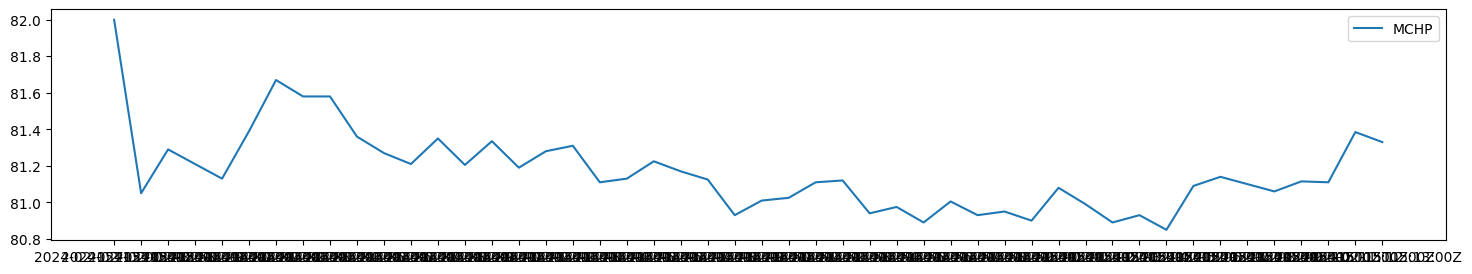

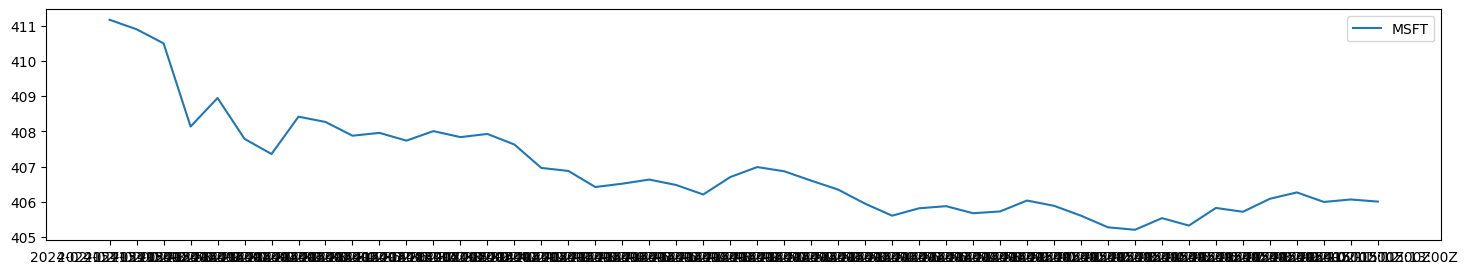

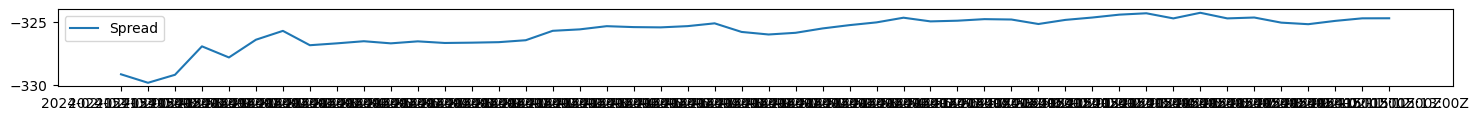

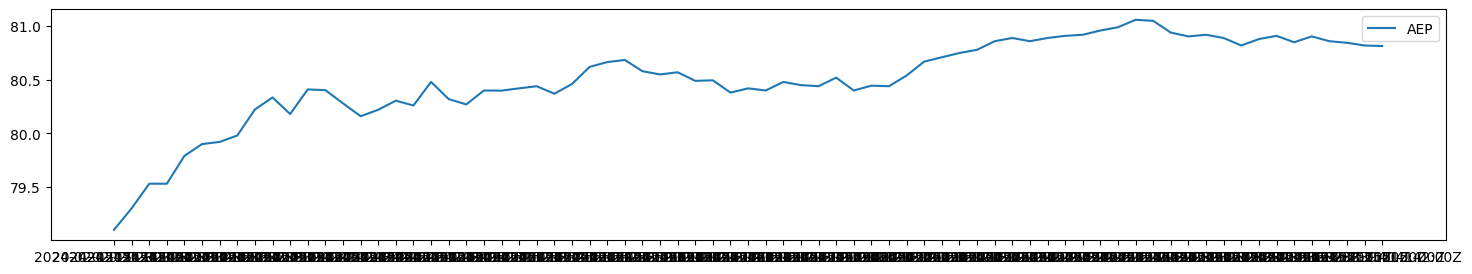

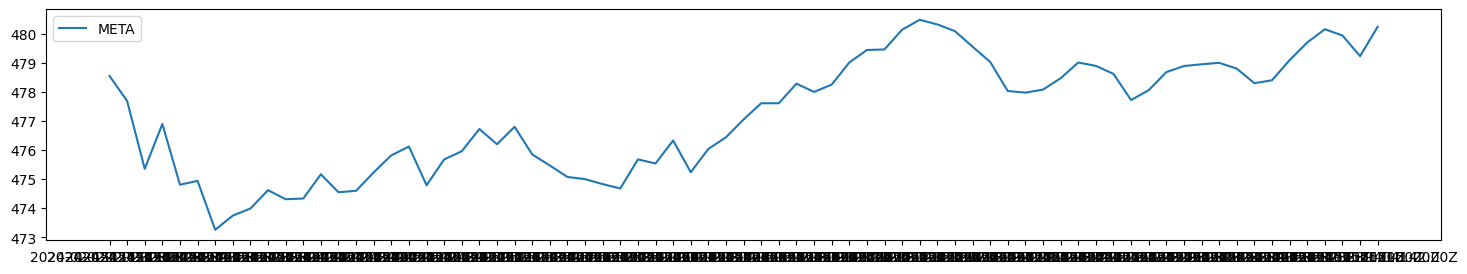

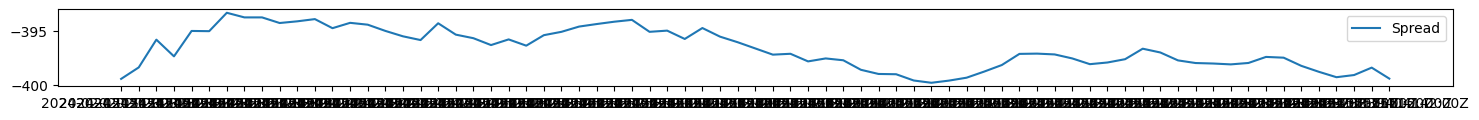

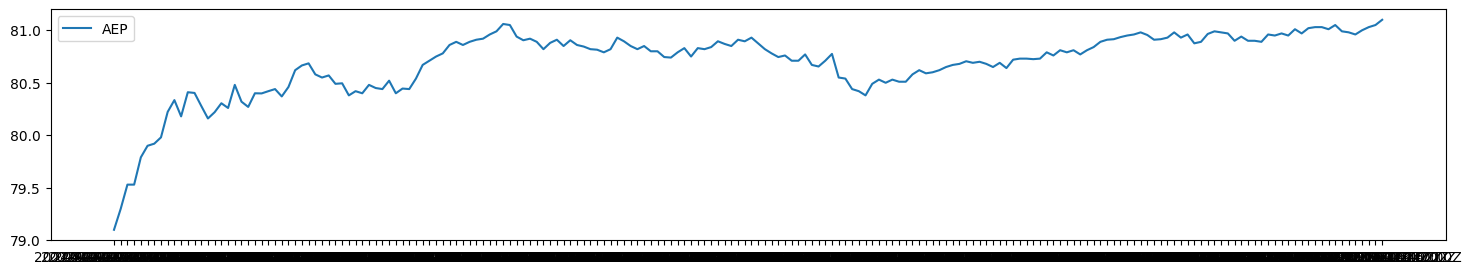

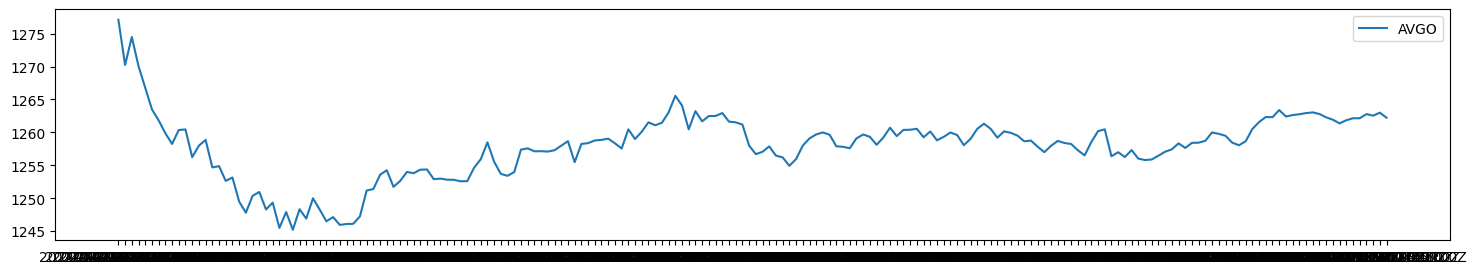

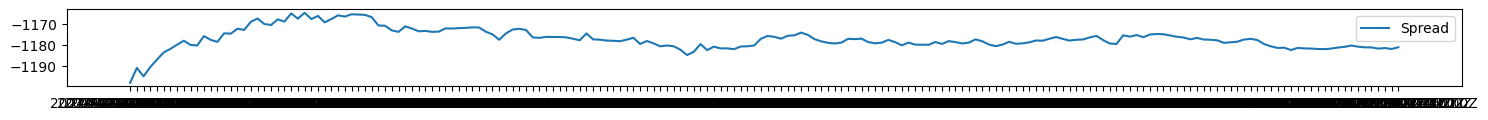

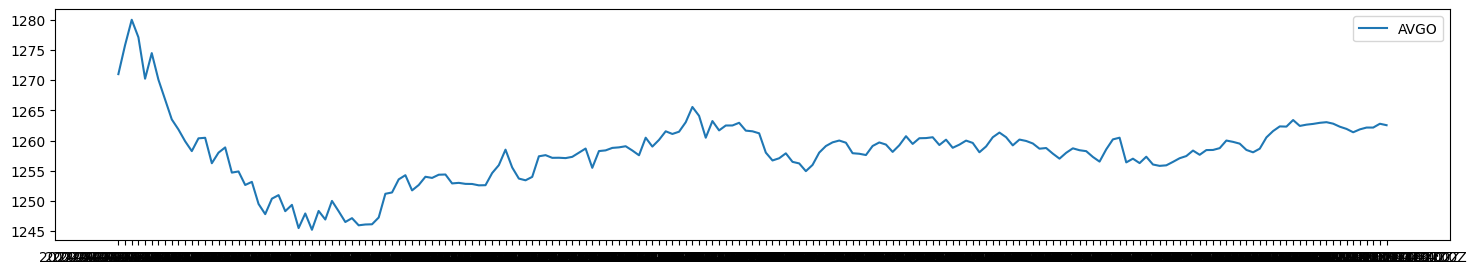

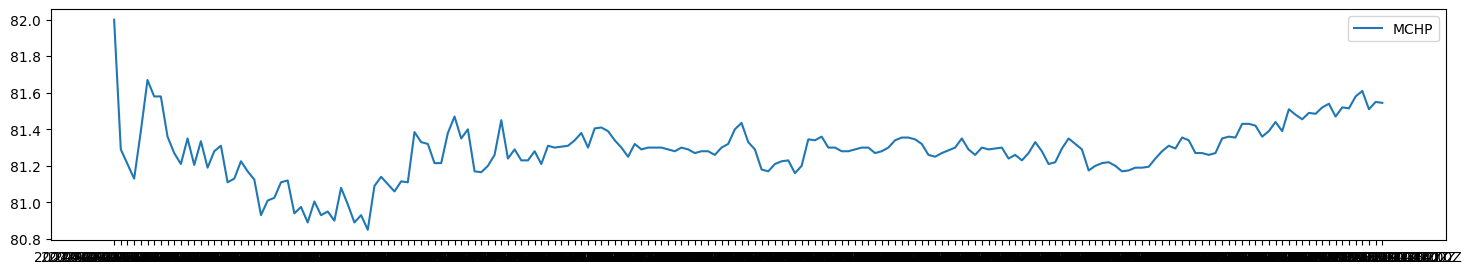

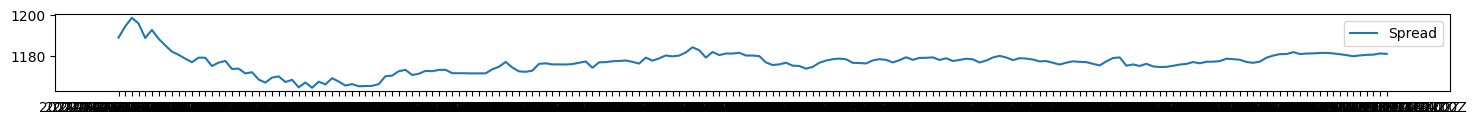

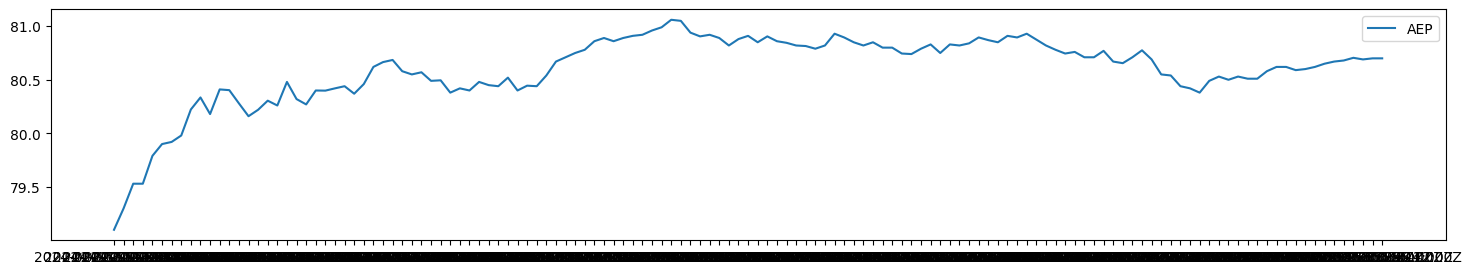

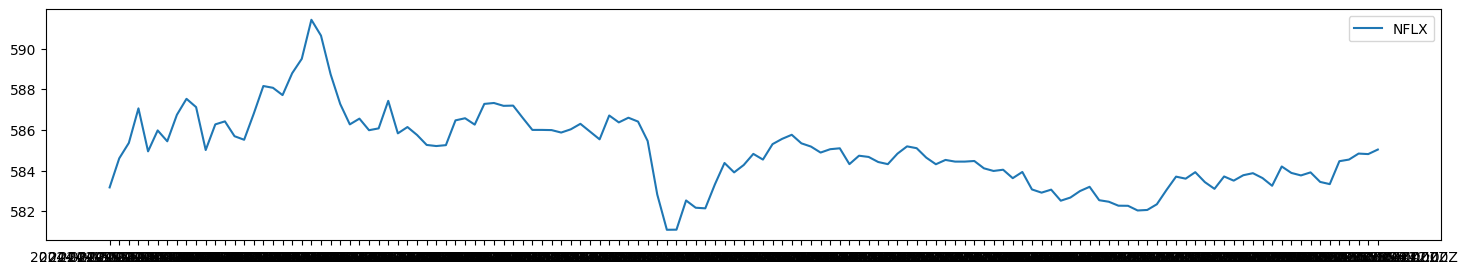

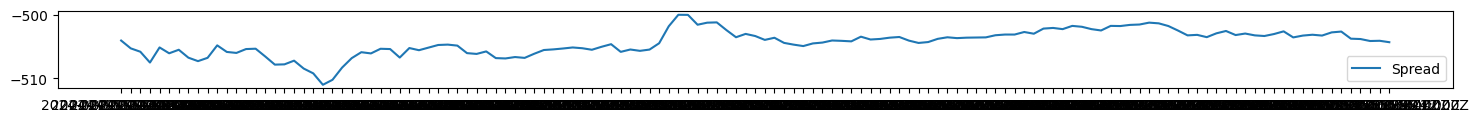

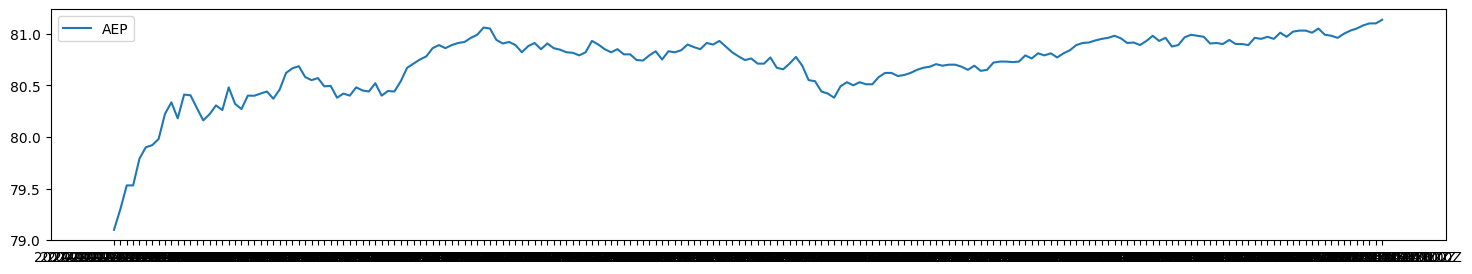

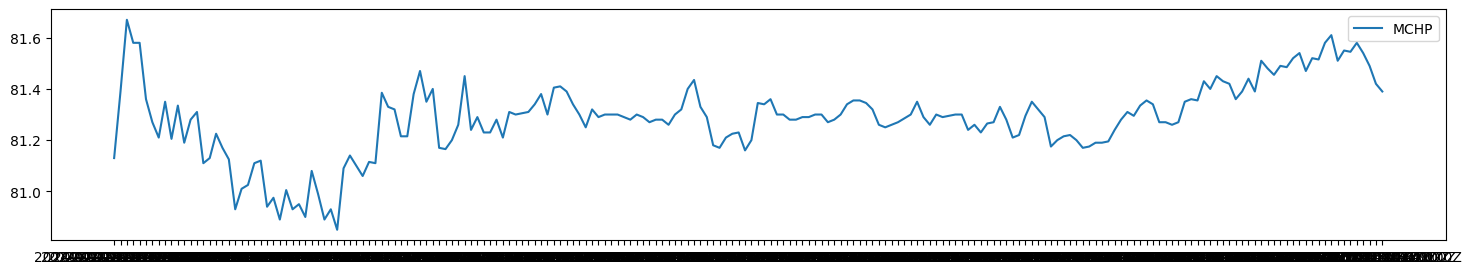

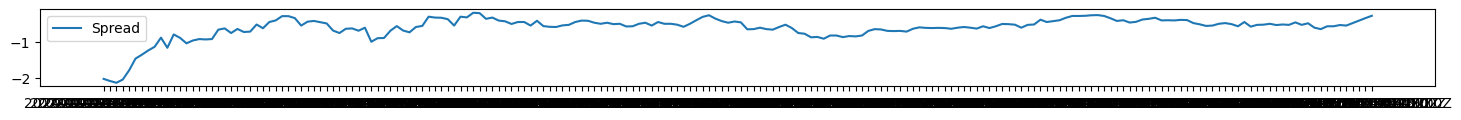

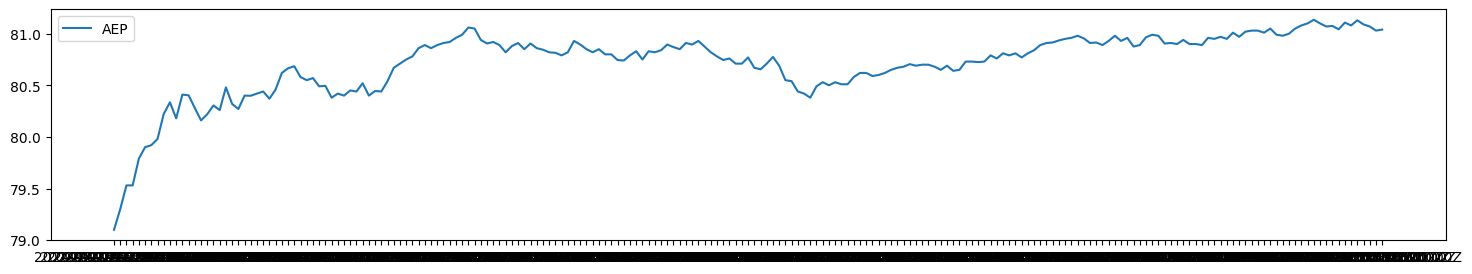

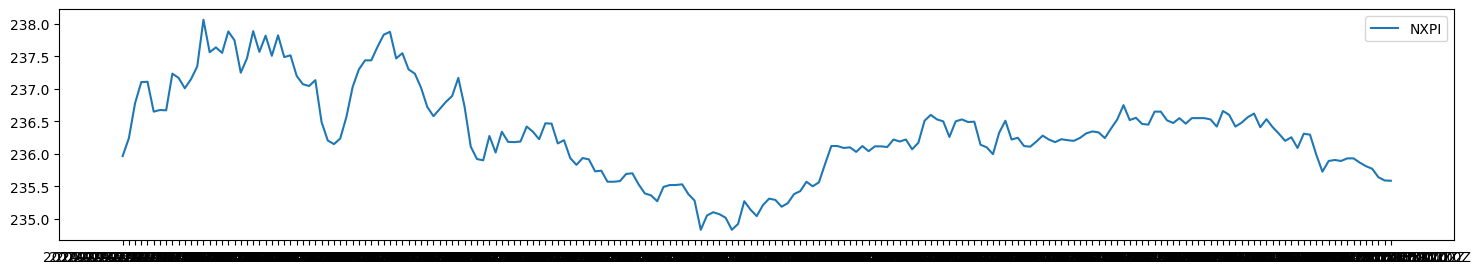

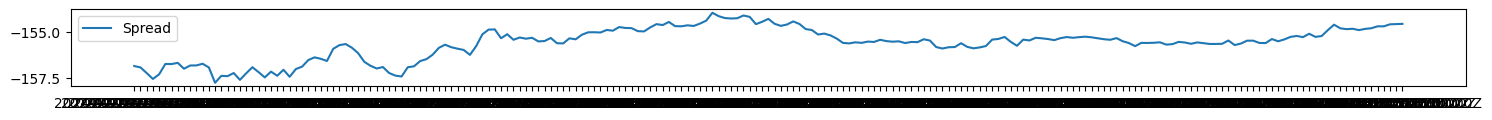

In [22]:
import matplotlib.pyplot as plt

def plot_spreads(pairs_dict):

  plt.figure(figsize=(18,3))
  plt.plot(pairs_dict["P_1"], label=pairs_dict["pair"].split("/")[0])
  plt.legend()

  plt.figure(figsize=(18,3))
  plt.plot(pairs_dict["P_2"], label=pairs_dict["pair"].split("/")[1])
  plt.legend()

  plt.figure(figsize=(18,1))
  plt.plot(pairs_dict["S"], label="Spread")
  plt.legend()

for pair in cointegrated_pairs:
  plot_spreads(pair)

The [Ornstein-Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)
is described by the following SDE:

$$ dX_t = \kappa (\theta - X_t) dt + \sigma dW_t .$$

The parameters are:
- $\kappa > 0$:  mean reversion coefficient
- $\theta \in \mathbb{R}$:  long term mean  
- $\sigma > 0$:   volatility coefficient

This process is Gaussian, Markovian and (unconditionally) stationary.

##### The previous SDE can be solved!  Let's do it!

First of all we can define the new process $Y_t = X_t - \theta$ such that the differential is equal $dY_t = dX_t$.      
The SDE becomes:

$$ dY_t = - \kappa \, Y_t \, dt + \sigma \, dW_t .$$

Let us introduce the function: $f(t,y) = y e^{\kappa t}$.      
This function has derivatives:

$$ \frac{\partial f}{\partial t} = y\, \kappa\, e^{\kappa t}  \quad \frac{\partial f}{\partial y} = e^{\kappa t}
\quad \frac{\partial^2 f}{\partial y^2} = 0 .$$

We can use the Itô formula:

$$ \begin{aligned}
d( Y_t \, e^{\kappa t} ) &= \kappa \, Y_t\, e^{\kappa t}\, dt + e^{\kappa t}\, dY_t \\
                         &= \kappa \, Y_t\, e^{\kappa t}\, dt + e^{\kappa t}\, \biggl( - \kappa \, Y_t \, dt + \sigma \, dW_t \biggr) \\
                         &= e^{\kappa t} \sigma dW_t .
\end{aligned} $$

For convenience, let us replace the time variable $t$ with $s$, and then let us integrate both sides on $[0,t]$:

$$ Y_t\, e^{\kappa t} - Y_0 = \int_0^t e^{\kappa s} \sigma dW_t .$$

At this point we can return to the original variable $X_t$ and obtain the final solution:

$$ X_t = \theta + (X_0 - \theta)e^{-\kappa t} + \int_0^t \sigma\, e^{\kappa (s-t)} dW_s .$$

<a id='sec1.1'></a>
## Numerical simulation

We can discretize the SDE using the Euler-Maruyama numerical method (see Notebook **1.2**).
This discretization is commented in the code below.

Another possibility is to generate the dynamics from the solution of the SDE.     
Let us consider the solution of the OU SDE obtained above. We can compute $X_{n+1}$ and consider the initial value at time $n$.

$$ X_{n+1} = \theta + (X_n - \theta)e^{-\kappa \Delta t} + \sqrt{\frac{\sigma^2}{2\kappa} \bigl( 1- e^{-2 \kappa \Delta t} \bigr)} \; \epsilon_n $$

with $\epsilon_n \sim \mathcal{N}(0,1)$.

In [ ]:
np.random.seed(seed=42)

N = 20000  # time steps
paths = 5000  # number of paths
T = 5
T_vec, dt = np.linspace(0, T, N, retstep=True)

kappa = 3
theta = 0.5
sigma = 0.5
std_asy = np.sqrt(sigma**2 / (2 * kappa))  # asymptotic standard deviation

X0 = 2
X = np.zeros((paths, N))
X[:, 0] = X0
W = ss.norm.rvs(loc=0, scale=1, size=(paths, N - 1))

# Uncomment for Euler Maruyama
# for t in range(0,N-1):
#    X[:,t+1] = X[:,t] + kappa*(theta - X[:,t])*dt + sigma * np.sqrt(dt) * W[:,t]

std_dt = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
for t in range(0, N - 1):
    X[:, t + 1] = theta + np.exp(-kappa * dt) * (X[:, t] - theta) + std_dt * W[:, t]

X_T = X[:, -1]  # values of X at time T
X_1 = X[1, :]  # a single path

#### Mean and standard deviation

Since we have the possibility to generate several paths, let us consider the values at time T. We compute theoretical mean and standard deviation and compare them with the values obtained from the data:

In [ ]:
mean_T = theta + np.exp(-kappa * T) * (X0 - theta)
std_T = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * T)))

param = ss.norm.fit(X_T)  # FIT from data
print(f"Theoretical mean={mean_T.round(6)} and theoretical STD={std_T.round(6)}")
print("Parameters from the fit: mean={0:.6f}, STD={1:.6f}".format(*param))  # these are MLE parameters

#### Plot

In [ ]:
N_processes = 10  # number of processes
x = np.linspace(X_T.min(), X_T.max(), 100)
pdf_fitted = ss.norm.pdf(x, *param)

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(T_vec, X[:N_processes, :].T, linewidth=0.5)
ax1.plot(T_vec, (theta + std_asy) * np.ones_like(T_vec), label="1 asymptotic std dev", color="black")
ax1.plot(T_vec, (theta - std_asy) * np.ones_like(T_vec), color="black")
ax1.plot(T_vec, theta * np.ones_like(T_vec), label="Long term mean")
ax1.legend(loc="upper right")
ax1.set_title(f"{N_processes} OU processes")
ax1.set_xlabel("T")
ax2.plot(x, pdf_fitted, color="r", label="Normal density")
ax2.hist(X_T, density=True, bins=50, facecolor="LightBlue", label="Frequency of X(T)")
ax2.legend()
ax2.set_title("Histogram vs Normal distribution")
ax2.set_xlabel("X(T)")
plt.show()

### Maximum Likelihood Estimation

We know that
$$ X_{i+1} \sim \mathcal{N}\biggl( \theta \bigl( 1-e^{-\kappa \Delta t} \bigr) + e^{-\kappa \Delta t} X_i \, , \, \frac{\sigma^2}{2\kappa} \bigl( 1- e^{-2 \kappa \Delta t} \bigr)\biggr)$$

Let us define $\hat \theta^2 := \frac{\sigma^2}{2\kappa} \bigl( 1- e^{-2 \kappa \Delta t} \bigr)$.

At this point it is possible to write the log-likelihood function and impose the condition that first order derivatives are equal to zero. All these steps are done in [1].
Here I just recall the final formulas:

$$ S_x = \sum_{i=1}^n X_{i-1} \quad S_y = \sum_{i=1}^n X_{i} \quad S_{xx} = \sum_{i=1}^n X_{i-1}^2
\quad S_{xy} = \sum_{i=1}^n X_{i-1}X_{i} \quad S_{yy} = \sum_{i=1}^n X_{i}^2$$

The parameters are:

$$ \theta = \frac{S_y S_{xx} - S_x S_{xy}}{n(S_{xx}-S_{xy}) - (S_{x}^2 - S_{x} S_{y})} $$

$$ \kappa = - \frac{1}{\Delta t} \log \frac{S_{xy} - \theta S_{x} - \theta S_{y} +n\theta^2}{S_{xx} - 2\theta S_{x} +n \theta^2} $$

$$
\hat \theta^2 = \frac{1}{n} \biggl[ S_{yy} -2e^{-\kappa \Delta t} S_{xy}
+ e^{-2 \kappa \Delta t} S{xx} -2\theta(1-e^{- \kappa \Delta t})(S_y - e^{- \kappa \Delta t}S_x)
+n \theta^2(1-e^{- \kappa \Delta t})^2 \biggr] $$
$$ \theta^2 = \hat \theta^2 \frac{2\kappa}{1-e^{-2 \kappa \Delta t}} $$

In [ ]:
Sx = np.sum(XX)
Sy = np.sum(YY)
Sxx = XX @ XX
Sxy = XX @ YY
Syy = YY @ YY

theta_mle = (Sy * Sxx - Sx * Sxy) / (N * (Sxx - Sxy) - (Sx**2 - Sx * Sy))
kappa_mle = -(1 / dt) * np.log(
    (Sxy - theta_mle * Sx - theta_mle * Sy + N * theta_mle**2) / (Sxx - 2 * theta_mle * Sx + N * theta_mle**2)
)
sigma2_hat = (
    Syy
    - 2 * np.exp(-kappa_mle * dt) * Sxy
    + np.exp(-2 * kappa_mle * dt) * Sxx
    - 2 * theta_mle * (1 - np.exp(-kappa_mle * dt)) * (Sy - np.exp(-kappa_mle * dt) * Sx)
    + N * theta_mle**2 * (1 - np.exp(-kappa_mle * dt)) ** 2
) / N
sigma_mle = np.sqrt(sigma2_hat * 2 * kappa_mle / (1 - np.exp(-2 * kappa_mle * dt)))

In [ ]:
print("theta MLE = ", theta_mle)
print("kappa MLE = ", kappa_mle)
print("sigma MLE = ", sigma_mle)

With the MLE we obtain parameters quite similar to those obtained by OLS.